# Multilevel slopes

In [1]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Train/Test data
train = pd.read_csv('../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

## Load and simulate fake data

In [26]:
# Import multilevel model
multilevel_slopes = pystan.StanModel(file = '../models/multilevel_slopes.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c731dd772e5d56baa9690d1d08f26fa NOW.


In [27]:
mls_data_check = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           run_estimation = 0)

fit_mls_check = multilevel_slopes.sampling(data=data_check)
df_mls_check = fit_model_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Prior predcitive checks

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12e216128>],
      dtype=object)

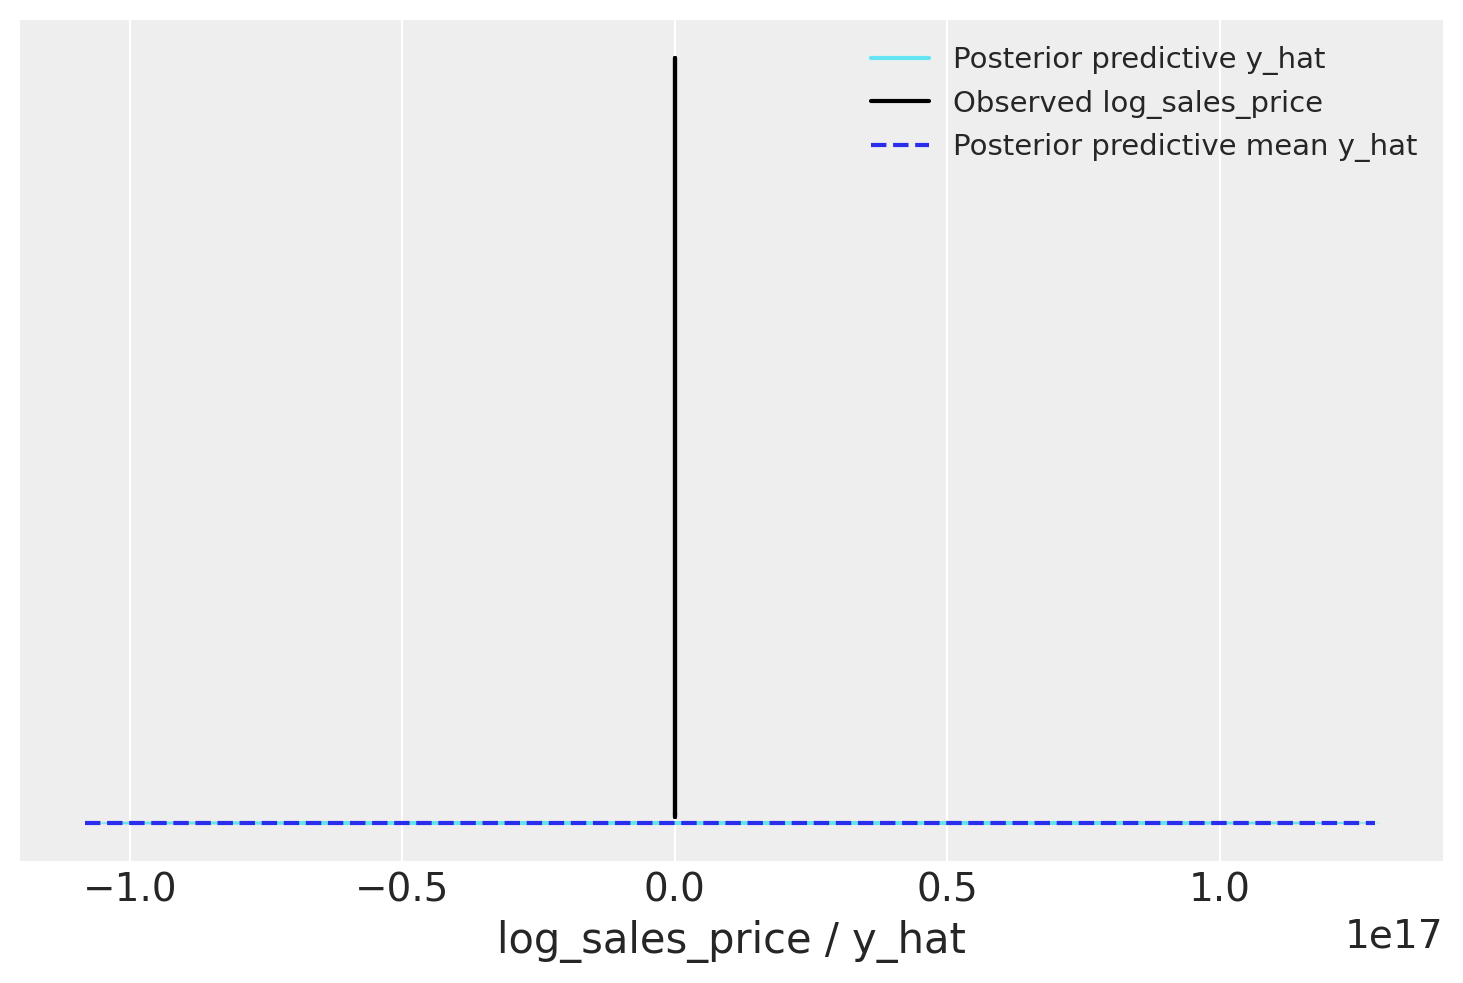

In [29]:
mls_check_az = az.from_pystan(
    posterior=fit_mls_check,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

az.plot_ppc(data = mls_check_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

#az.plot_trace(fit_model_check, var_names=["alpha_j", "beta", "sigma"], compact = True);

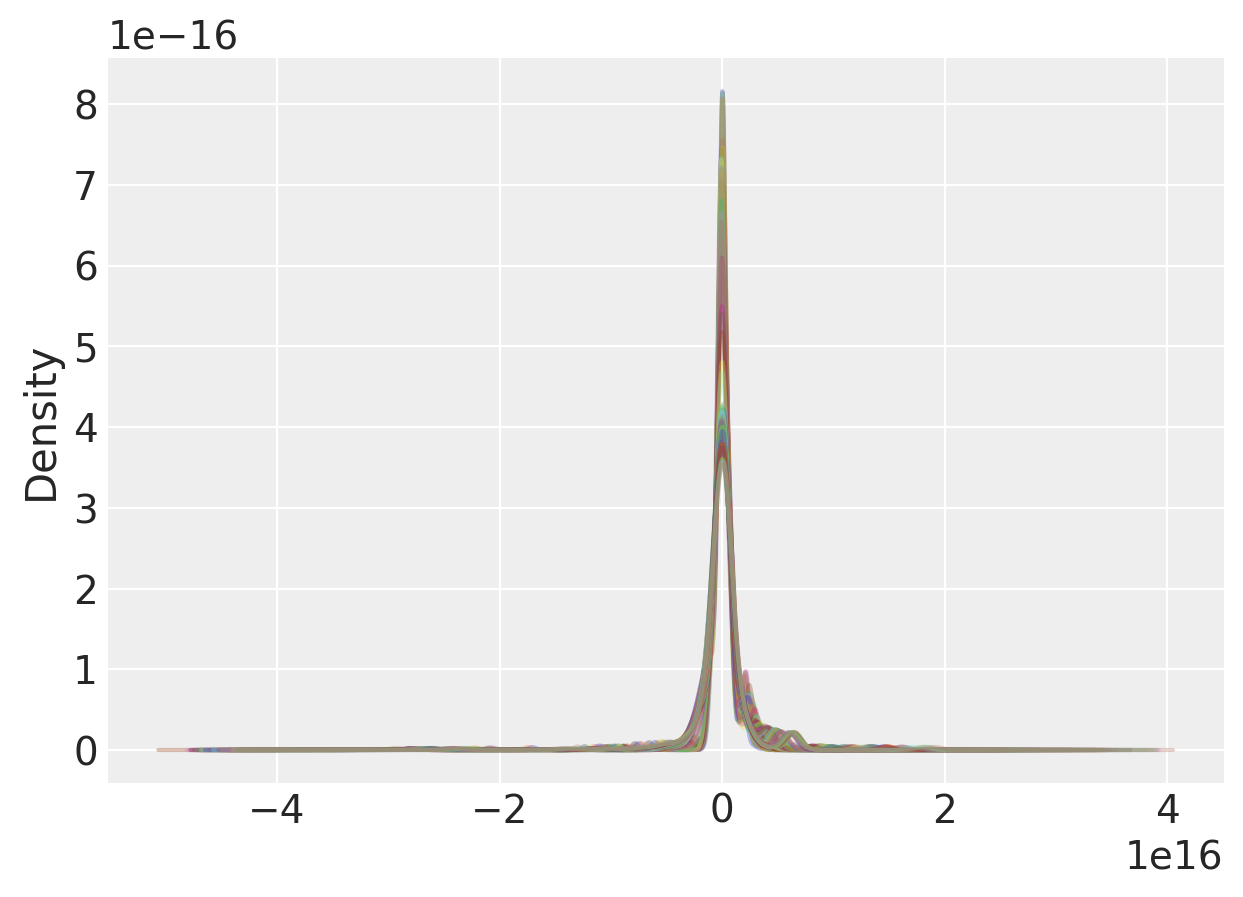

In [38]:
fig, axes = plt.subplots(1,1)

df_mls_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False,
                                                               ax=axes);

#train['log_sales_price_std'].plot.kde(legend = False, 
#                             alpha = 1,
#                             ax = axes);

In [ ]:
## Fit model on fake data and recapture known parameters (appendix?)

## Fit model on real data

In [31]:
mls_data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           run_estimation = 1)

# Fit model
fit_mls = multilevel_slopes.sampling(data=mls_data)

mls_az = az.from_pystan(
    posterior=fit_mls,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

fit_mls_df = fit_mls.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Posterior predictive check

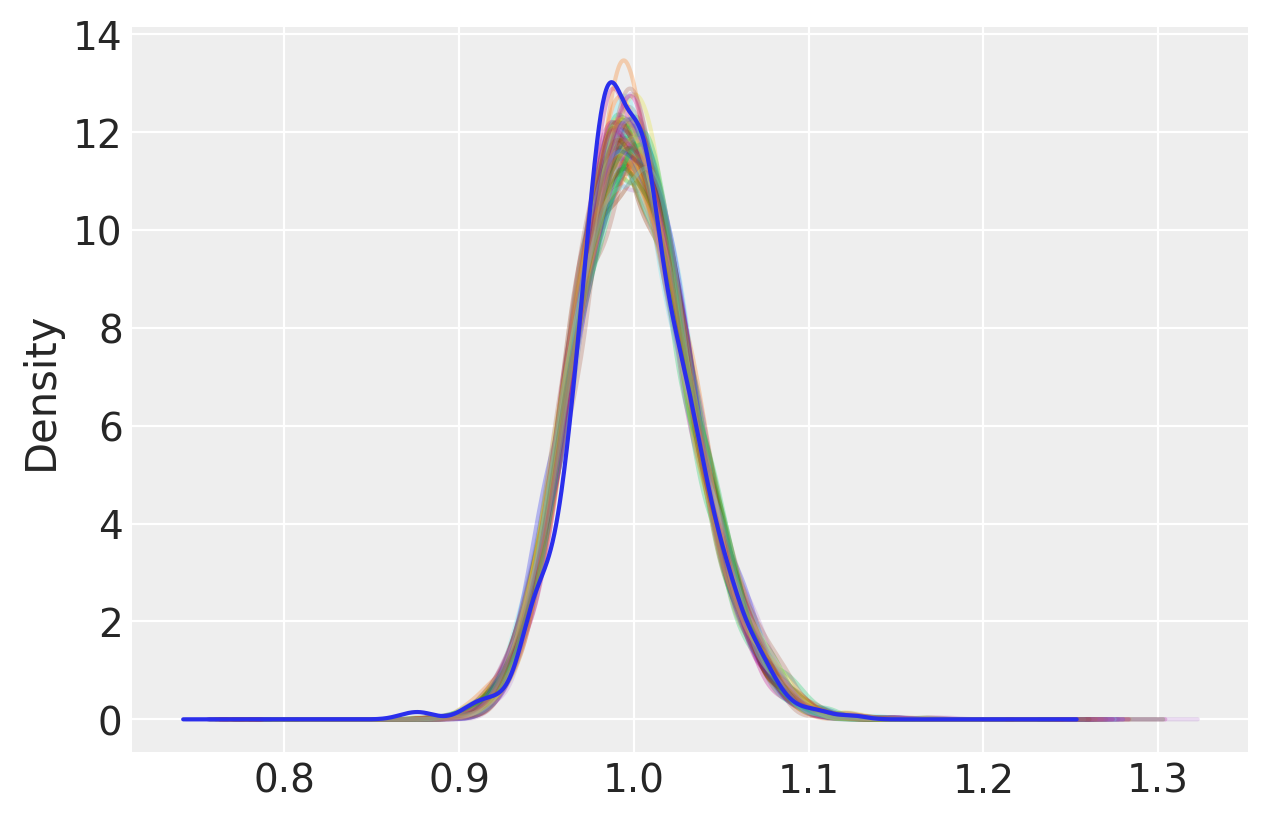

In [39]:
fig, axes = plt.subplots(1,1)

fit_mls_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False,
                                                               ax=axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1264dd860>],
      dtype=object)

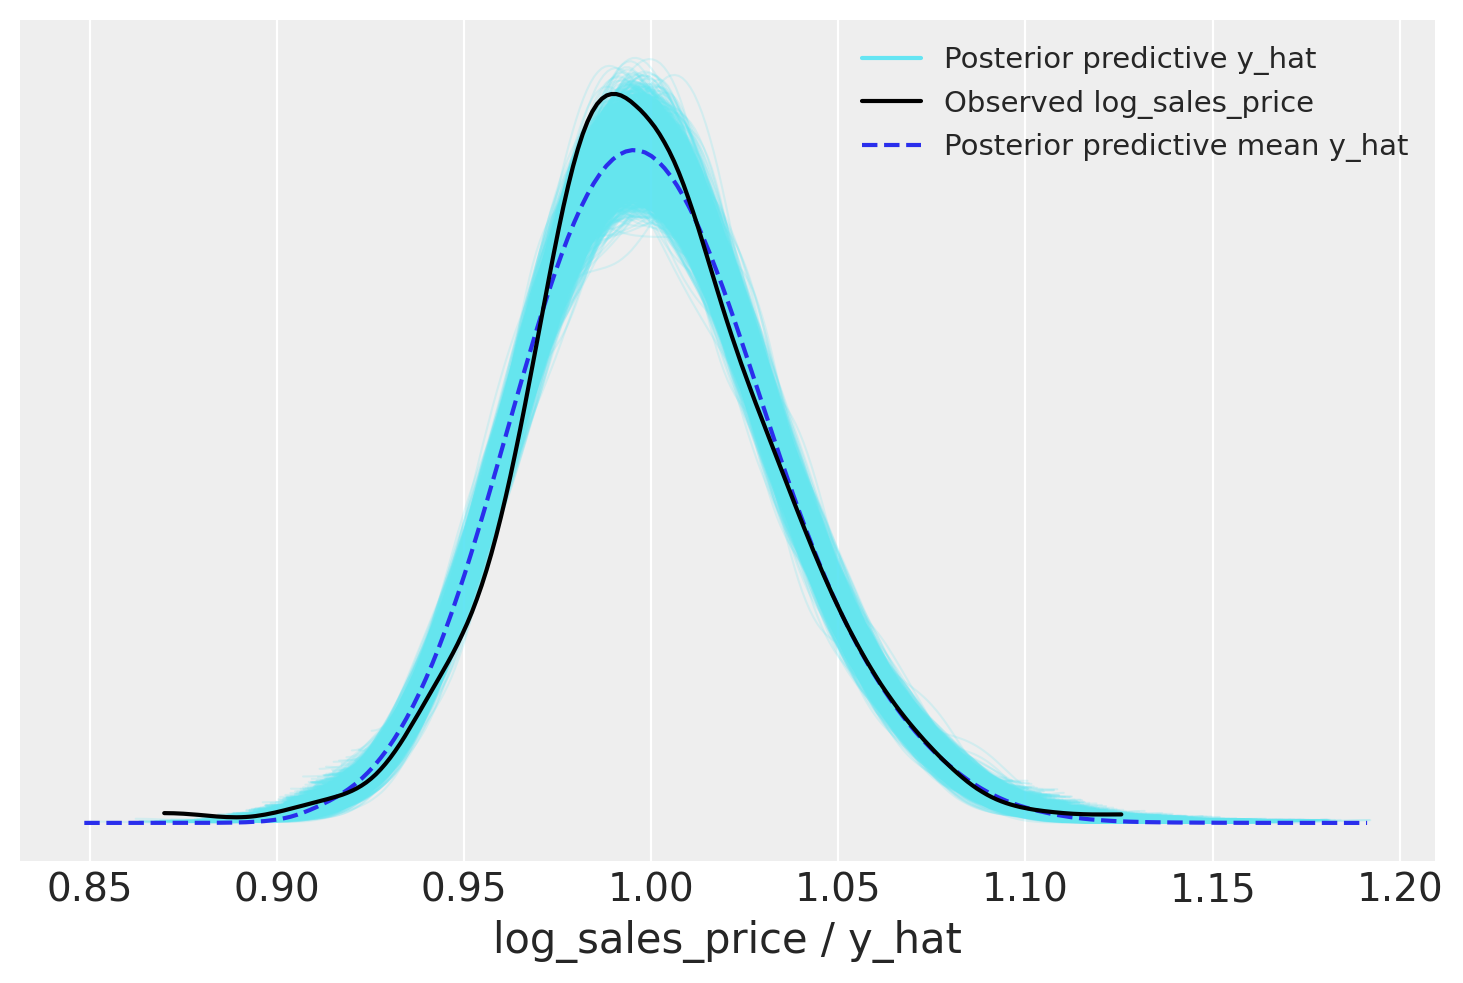

In [32]:
az.plot_ppc(data = mls_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

## Trace plots

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor


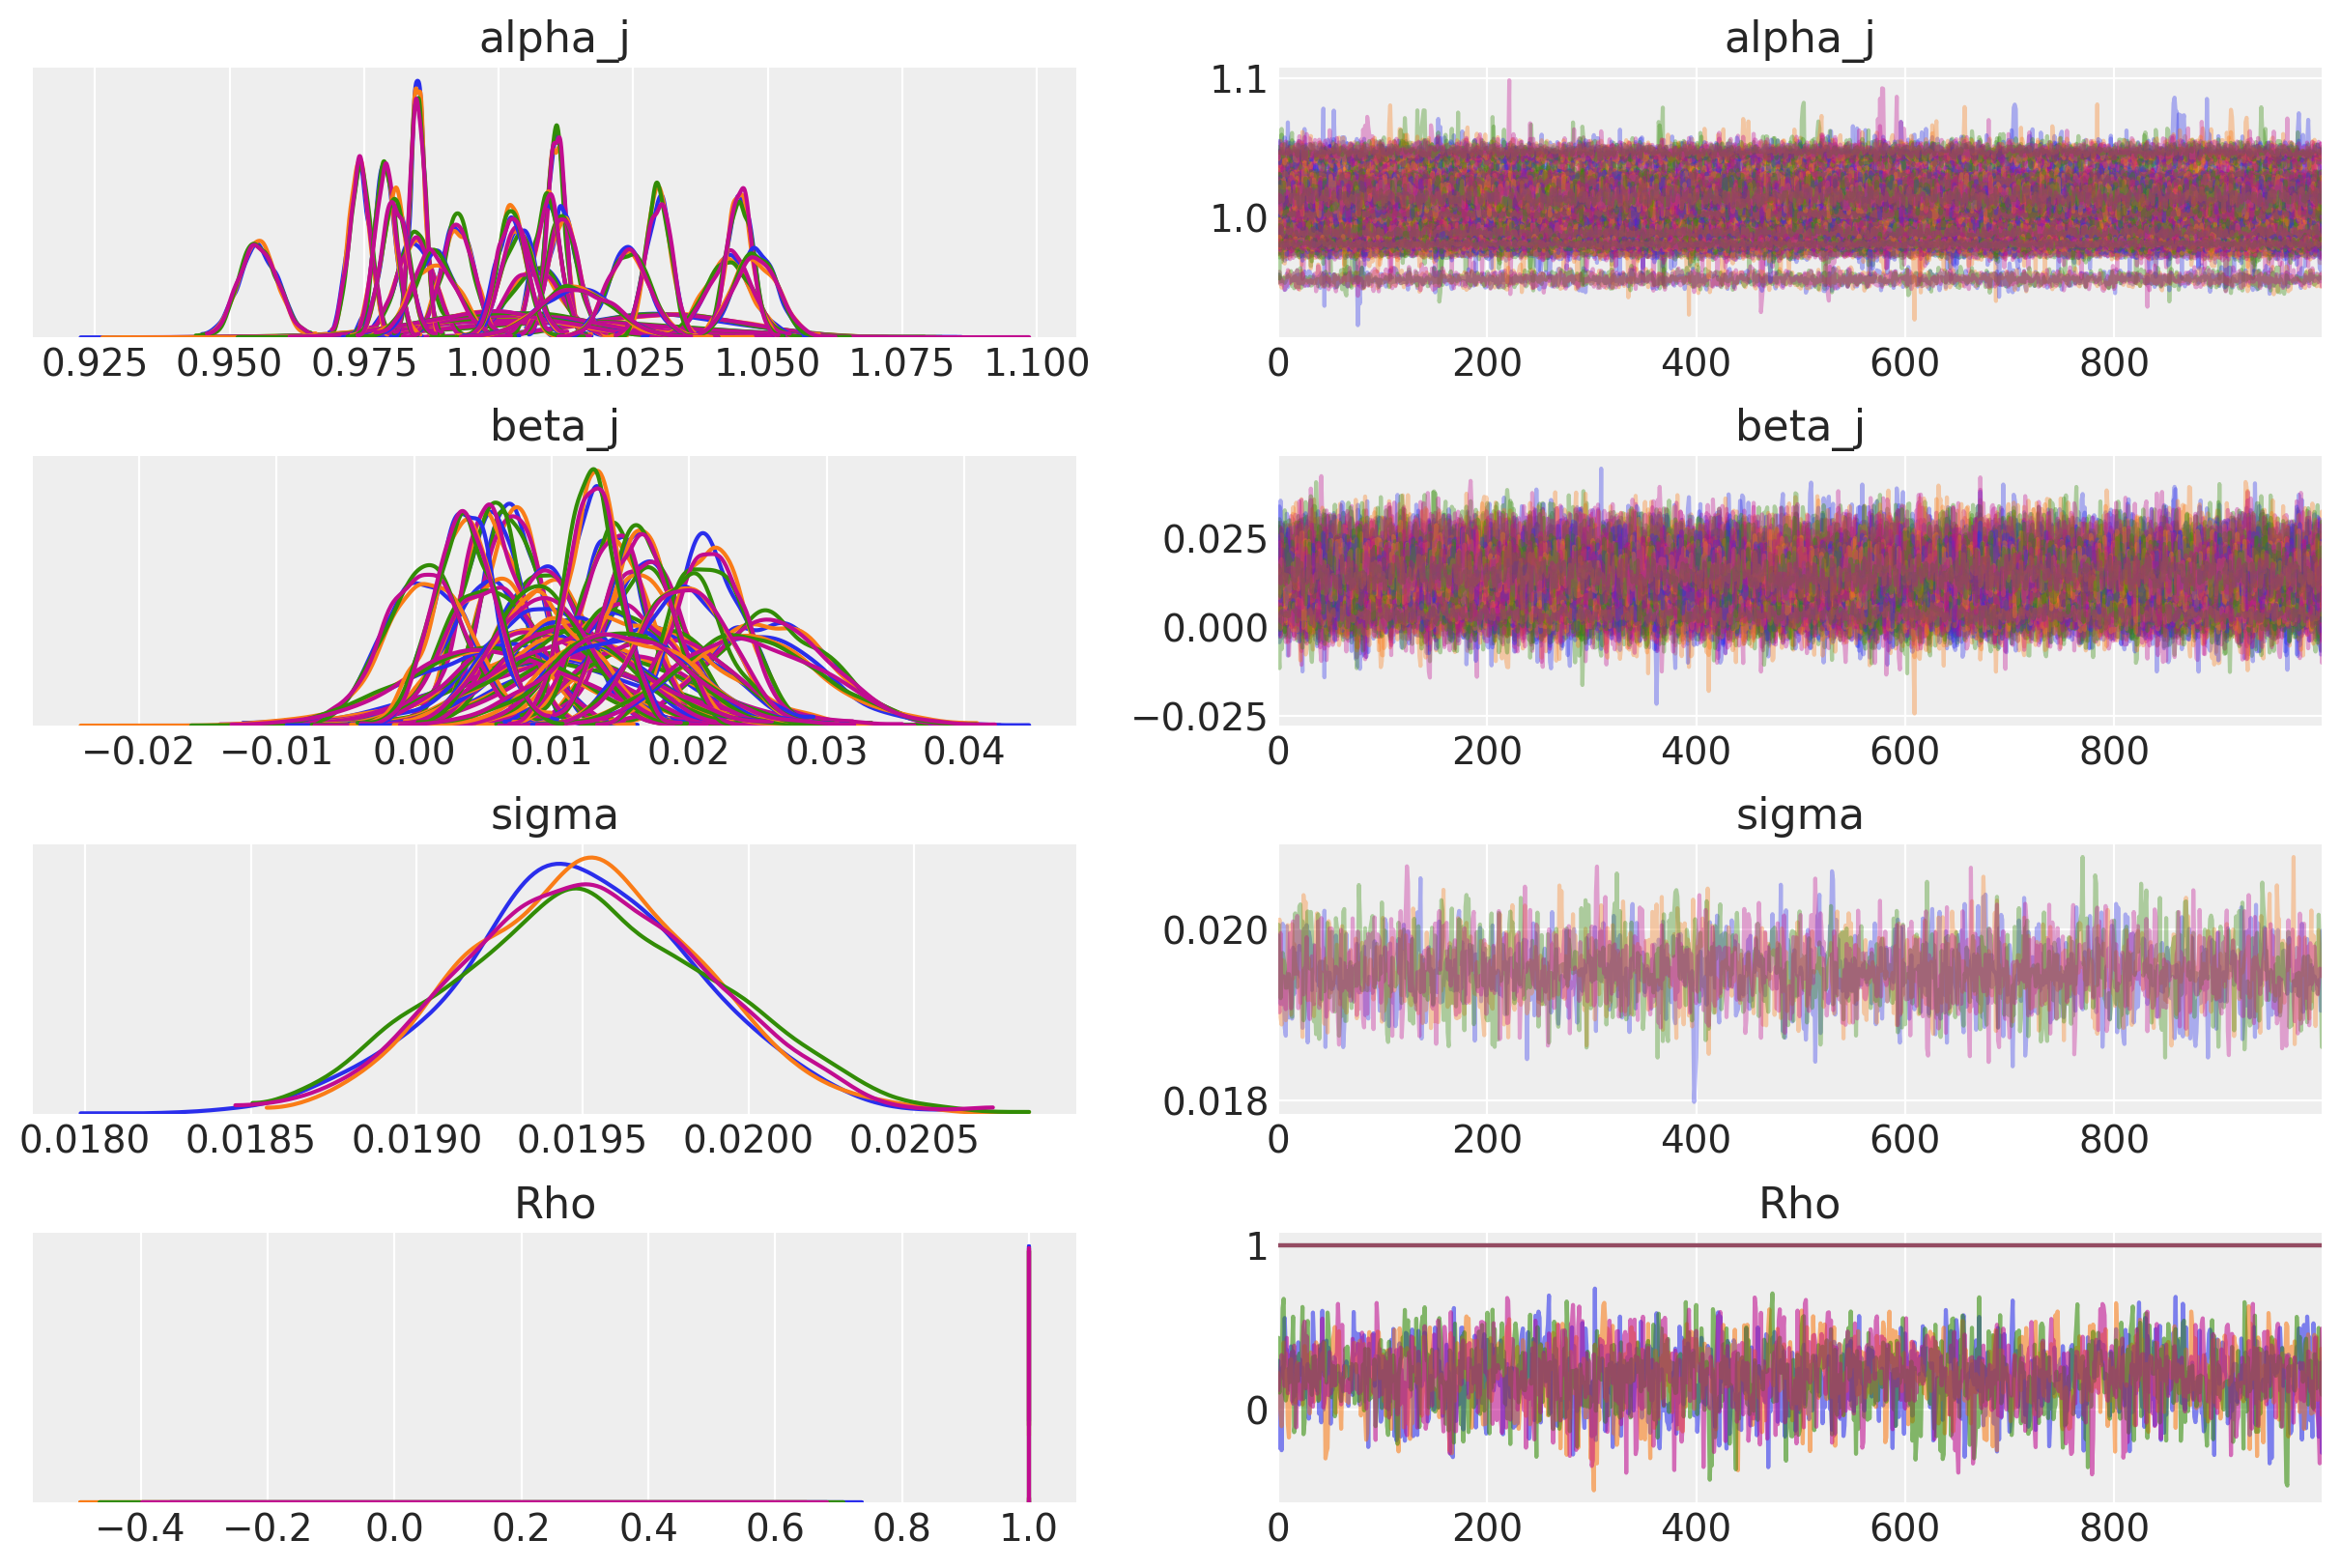

In [34]:
az.plot_trace(fit_mls, var_names=["alpha_j", "beta_j", "sigma", "Rho"], compact = True);

## Posterior predictive checks on raw scale

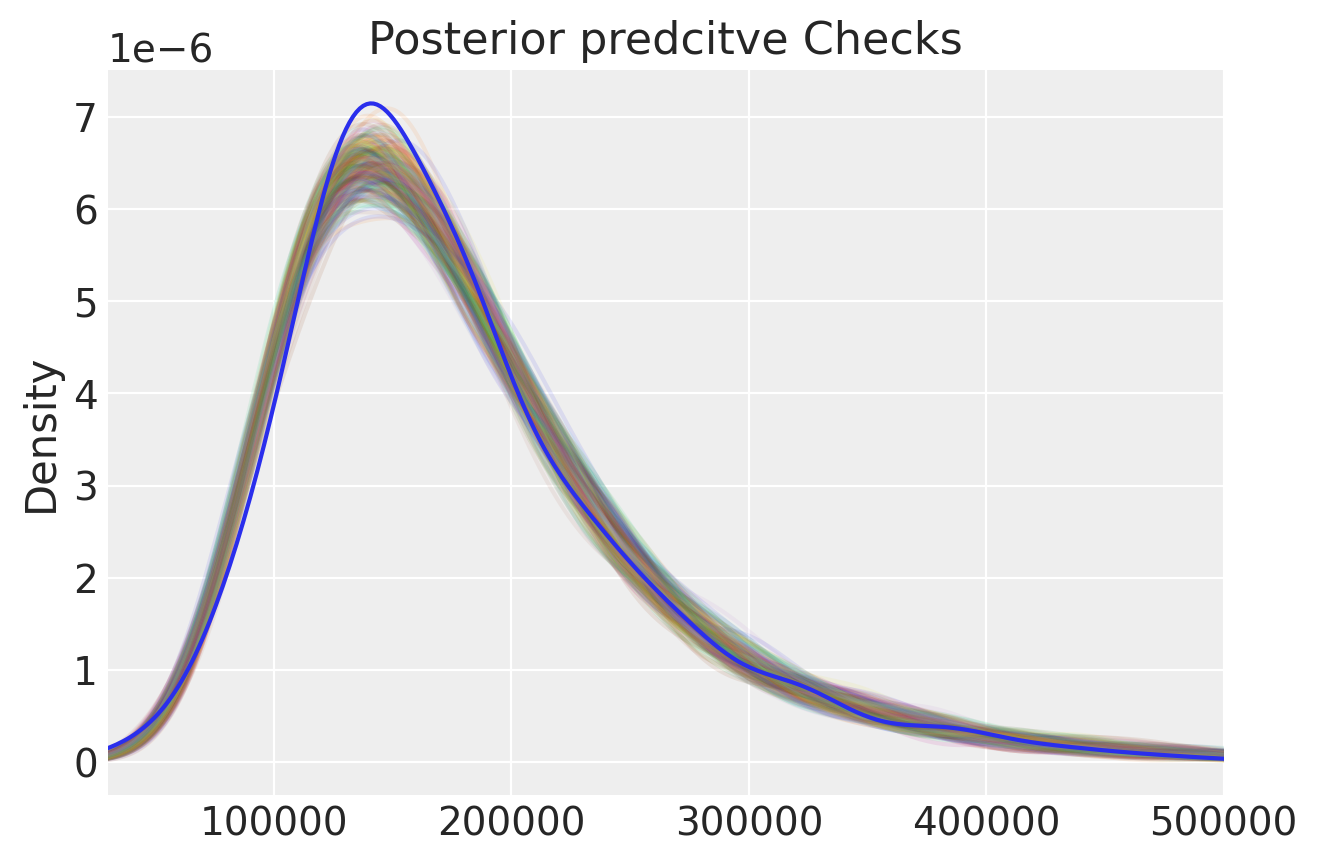

In [42]:
fig, axes = plt.subplots(1,1)
np.exp(fit_mls_df.filter(regex = 'y_hat')*train['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predcitve Checks', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.1,
                                                                                                  ax = axes);
train['SalePrice'].plot.kde(legend = False, 
                             xlim = (30000,500000),
                             alpha = 1,
                             ax = axes);

In [41]:
predictions = pd.DataFrame(np.exp(fit_mls_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

multilevel_slope_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

multilevel_slope_csv.to_csv('../data/submissions/multilevel_slope.csv', index = False)

In [44]:
%%sh
cd ../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f multilevel_slope.csv -m "Partial pooling (multilevel slopes)"

Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.6k/33.6k [00:07<00:00, 4.91kB/s]
